In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
# Chargement des librairies
import datetime
import time
import sys
import os
import string
import json
from datetime import datetime
import jyquickhelper
import typing

import seaborn as sns
import matplotlib as mpl

# Warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
# Chargement à chaud des librairies personnelles

# <span class="bg-primary">POC CLASSIFICATION<span>
##  <span style='background:PaleGreen'>PARTIE 2 : MODELISATION ONLINE AVEC RIVER </span>
##  <span style='background:PaleGreen'>SCRIPT</span>

## <span style='background:Thistle'>Mission</span> 
***
- Notre mission est d'automatiser la classification de documents ajoutés par le client à partir :
    - [x] **des descriptions textuelles des documents**,
    - [x] **des titres des documents**
mis à disposition dans le jeu de données.
- Une colonne cible contenant la référence des différents types de documents a été ajoutée par nos soins :
    - [x] **labels**

## <span style='background:Thistle'>Sommaire du notebook</span> 

In [ ]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## <span style='background:Thistle'>Versions</span> 

In [7]:
# Versions
print('Version des librairies utilisées :')
print('jyquickhelper         : ' + jyquickhelper.__version__)
print('Python                : ' + sys.version)
print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Matplotlib            : ' + mpl.__version__)
print('Seaborn               : ' + sns.__version__)

now = datetime.now().isoformat()
print('Lancé le           : ' + now)

Version des librairies utilisées :
jyquickhelper         : 0.4.220
Python                : 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
NumPy                 : 1.21.2
Pandas                : 1.3.3
Matplotlib            : 3.3.2
Seaborn               : 0.11.0
Lancé le           : 2021-10-14T17:45:16.945249


## <span style='background:Thistle'>Options</span> 

In [8]:
dico_pd_option = {
    'display.max_rows': 2500,
    'display.max_column': 200,
    'display.width': 300,
    'display.precision': 5,
    'display.max_colwidth': 1000,
    'mode.chained_assignment': None
}
for cle, val in dico_pd_option.items():
    pd.set_option(cle, val)

## <span class="bg-info">1. Chargement du jeu de données transformé en CSV</span>

In [10]:
df_work = pd.read_csv('df_work.csv')
df_work.head(1);

,title,texte,label,texte_clean,texte_clean_stem,texte_clean_lemma,title_clean,title_stem,title_lemma
0,2004-CP101-#SY2004.1-#D201700-CONVOC AGO-Convocation AG 20-09-17.pdf,"\n\n \n\n7 ADRESSE IMMEUBLE -\n\nAFUT, MURAT\n\n4-22 PLACE DES MAITRES VIGNERONS\n92506 RUEIL MALMATSON\n\nMANDAT MEMBRE AFUL\n\nOGIF\n18 BIS RUE DE VILLIERS\n\n \n\n92594 LEVALLOIS-PERRET\n\n \n\n \n\n \n\n \n\nPOUVOIR\n\nJe soussigné{a)\n\nagissant en qualité de copropriétaire de l'immeuble précité constitue pour\nmandataire\n\nou à son défaut :\n\npour me représenter à l'assemblée générale : AFUL MURAT\n\npour le 20 SEPTEMBRE 2017\n\n| En conséquence, assister à l'assemblée, signer ies feuilles de\nprésence et toutes autres Pièces, prendre part À toutes les délibérations, émettre\n\ntous votes, sur les questions mentionnées à l'ordre du jour et généralement faire\nle nécessaire.\n\nIL est rappelé que le syndic ne peut pas représenter un copropriétaire et que\nchacun des copropriétaires ne peut recevoir que trois pouvoirs, Il peut recevoir\n\nplus de trois pouvoirs si 1e total des voix dont il dispose n'excède pas 5 % des\nvoix du syndicat.\n\nLe\nFaire précéder la signature de\...",CP101,adresse immeuble afut murat place maitres vignerons rueil mandat membre aful ogif bis rue villiers levallois perret pouvoir soussigné agissant qualité copropriétaire immeuble précité constitue mandataire défaut représenter aful murat septembre conséquence assister signer ies feuilles présence toutes autres pièces prendre part toutes délibérations émettre votes questions mentionnées ordre jour généralement nécessaire rappelé représenter copropriétaire chacun recevoir trois pouvoirs recevoir plus trois pouvoirs e total voix dont dispose excède voix syndicat précéder signature pouvoir aful zac dés godardes eo place maîtres vignerons rueil malmaison mi rueil cote titre peer coda ape ee rte ti eee prélecture nanterre garentie compte fetal ron lp eee ordre jour nomination president seance nomination er scrutateur seance nomination eme scrutateur seance nomination secretaire seance rapport act...,adress immeubl afut murat place maitr vigneron rueil mandat membr aful ogif bis rue villier levalloi perret pouvoir soussigné agiss qualité copropriétair immeubl précité constitu mandatair défaut représent aful murat septembr conséquenc assist signer ie feuill présenc tout autr pièc prendr part tout délibérat émettr vote question mentionné ordr jour généralement nécessair rappelé représent copropriétair chacun recevoir troi pouvoir recevoir plus troi pouvoir e total voix dont dispos excèd voix syndicat précéder signatur pouvoir aful zac dés godard eo place maîtr vigneron rueil malmaison mi rueil cote titr peer coda ape ee rte ti eee prélectur nanterr garenti compt fetal ron lp eee ordr jour nomin presid seanc nomin er scrutateur seanc nomin eme scrutateur seanc nomin secretair seanc rapport activit conseil syndic approb compt travaux modif statut aful approb compt travaux securit incendi park approb compt travaux securit incendi park approb compt exercic quitus cabinet socerm gesti...,adresse immeuble afut murat place maitres vignerons rueil mandat membre aful ogif bi rue villiers levallois perret pouvoir soussigné agissant qualité copropriétaire immeuble précité constitue mandataire défaut représenter aful murat septembre conséquence assister signer y feuilles présence toutes autres pièces prendre part toutes délibérations émettre vote question mentionnées ordre jour généralement nécessaire rappelé représenter copropriétaire chacun recevoir trois pouvoirs recevoir plus trois pouvoirs e total voix dont dispose excède voix syndicat précéder signature pouvoir aful zac dés godardes eo place maîtres vignerons rueil malmaison mi rueil cote titre peer coda ape ee rte ti eee prélecture nanterre garentie compte fetal ron lp eee ordre jour nomination president seance nomination er scrutateur seance nomination eme scrutateur seance nomination secretaire seance rapport activite conseil syndical a

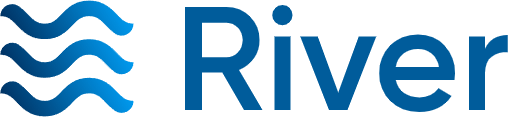

In [11]:
from pyquickhelper.helpgen import NbImage
NbImage("river_logo.png")

# <span style='background:Thistle'>OUTILS pour Online /Incremental Machine Learning </span> 
Outils d'apprentissage automatique en ligne/en différé

+ Offline ML Learning : icela signifie que nous avons un lot de données, et que nous optimisons une équation pour faire une prédiction. 
+ Online ML learning: utilisé lorsque nous avons des données en continu, où nous voulons traiter un échantillon de données à la fois.
    - données en temps réel, une observation à la fois
    - mise à jour des estimations à l'arrivée de chaque nouveau point de données plutôt que d'attendre la "fin" (qui peut ne jamais se produire).
+ L'apprentissage incrémental est une méthode d'apprentissage automatique dans laquelle les données d'entrée sont utilisées en permanence pour étendre les connaissances du modèle existant, c'est-à-dire pour poursuivre l'entraînement du modèle. 
+ Il s'agit d'une technique dynamique d'apprentissage supervisé et d'apprentissage non supervisé qui peut être appliquée lorsque les données d'apprentissage deviennent progressivement disponibles au fil du temps ou que leur taille dépasse les limites de la mémoire du système.
+ The AIM
    - le modèle d'apprentissage s'adapte aux nouvelles données sans oublier ses connaissances existantes.


- [x] __Outils pour Incremental or Online ML__
+ River
    - Creme
    - Scikit-Multiflow
+ MOA
+ SAMOA
+ StreamDB (spark streaming)


- [x] __Utilité__
+ Pour Online ML 
+ Pour le ML on streaming data


- [x] __Défis__
+ Difficile à gérer
    - Très adaptatif
+ Plus de niveaux de recherche


- [x] __Installation__
+ pip install river
+ pip install creme
+ pip install scikit-multiflow

# <span style='background:Thistle'>L'API RIVER</span>

Tous les modèles sont capables d'apprendre des données et de faire des prédictions.

Les modèles dans river ont la possibilité d'__apprendre à partir d'une seule instance__. 

Les modèles peuvent être mis à jour __rapidement chaque fois que de nouvelles données arrivent.__

- [x] __learn_one(x, y)__ met à jour l'état interne du modèle en fonction d'une nouvelle observation contenant des caractéristiques en entrée x et une valeur cible y.
- [x] __predict_one__ (classification, régression, clustering) renvoie la prédiction du modèle pour une seule observation
- [x] __predict_proba_one__ (classification) renvoie la probabilité prédite du modèle pour une seule observation
- [x] __score_one__ (détection d'anomalies) renvoie le score aberrant pour une seule observation
- [x] __transform_one__ transforme une observation d'entrée

River s'attend à ce que les observations de données soient présentées __sous forme de dictionnaires Python__. 

Les clés du dictionnaire représentant les noms des variables.

Une structure de données de dictionnaire présente plusieurs avantages :
- [x] Les dictionnaires sont flexibles et ne sont pas dactylographiés. Ainsi, ils peuvent gérer des données éparses et de nouvelles fonctionnalités qui peuvent apparaître dans le flux de données.
- [x] Les données du dictionnaire sont légères et ne nécessitent pas la surcharge requise par une structure de données sophistiquée telle que numpy.ndarray ou pandas.DataFrame. 

__Cela facilite le traitement rapide des observations individuelles dans un contexte de streaming.__

### <span class="bg-success">1.1. SCRIPT préparation/modélisation avec RIVER</span>

In [20]:
# Load Estimators
from river.feature_extraction import BagOfWords,TFIDF
from river import stream
from river import compose
from river.compose import Pipeline
from river import linear_model
from river import optim
from river import preprocessing
from river import metrics
from river import feature_extraction
from river.naive_bayes import ComplementNB
from river.naive_bayes import MultinomialNB as MNB_RIVER
from river.naive_bayes import GaussianNB
from river import base

#  Make a Pipeline
from river.compose import Pipeline
# Classification
from river.metrics import ClassificationReport

from sklearn.model_selection import train_test_split
from pprint import pprint

In [119]:
# Fonction Préparation/ModélisationPrediction du dataframe pour river (dictionnaire, iter_pandas)

def model_for_river(df, seuil, vectorizer, col_vect, classifier):
    
    df = df.astype(np.str) # string
    data_seuil = df.groupby('label').agg({'texte':'count'}).reset_index()
    label_ok = []
    for index, row in data_seuil.iterrows() :
        if data_seuil['texte'][index]>seuil:
            label_ok.append(data_seuil['label'][index])
    print('')         
    print('') 
    print(f'********************************************************************************************************')
    print('')
    print(f'                               Colonne vectorisée : {col_vect}                                          ')
    print('')
    print(f'Vectorisation : {vectorizer}                                                                            ')
    print(f'Modèle : {classifier}                                                                                   ')
    print(f'Seuil : {seuil} textes minimum par label                                                                ')      
    print('')
    print('')
    print(f'********************************************************************************************************')
    print('')
    print('')
    print(f'############################   FILTRAGE DU DATAFRAME (classes > seuil)    ##############################') 
    print('')
    print(f'Nombre de labels conservés (>seuil) : {len(label_ok)}')
    print('')
    print(f'Labels conservés contenant {seuil} textes minimum par label :')
    print(f'{label_ok}')
    df = df[df['label'].isin(label_ok)]
    print('')
    print(f'Taille du dataframe après filtrage : {df.shape}')
    print('')
    X = df
    y = df.pop('label')
    
    print(f'################## PREPARATION DU JEU DE DONNEES POUR RIVER (dictionnaire, iter_pandas) ###################')
    print('')
    print(f'                        SEPARATION DU JEU DE DONNEES EN TRAIN ET TEST SET    ')
    print('')
    
    # split the dataset into test set and train set
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size = 0.2, random_state = 23)
    print(f'Taille des dataframes : X_train : {X_train.shape}, y_train : {y_train.shape}') 
    print(f'                        X_test : {X_test.shape},   y_test : {y_test.shape}')
    print('')
    print(f'########### #####    PREPARATION DU JEU DE DONNEES TRAIN ET TEST POUR RIVER (iter_pandas)    ##############')
    print('')
    # Préparation du jeu de données TRAIN pour river (dictionnaire, iter_pandas)
    data_stream_train = stream.iter_pandas(X_train, y_train)
    
    # Préparation du jeu de données TEST pour river (dictionnaire, iter_pandas)
    data_stream_test = stream.iter_pandas(X_test, y_test)
        
    print(f'#######################################     PIPELINE     ##################################################')
    print('')

    #  Make a Pipeline
    from river.compose import Pipeline
    from river.feature_extraction import BagOfWords, TFIDF
    pipe_nb = Pipeline(('vectorizer', vectorizer(on=col_vect,strip_accents=False, lowercase=False)),
                   ('nb', classifier))
    print(pipe_nb)
    print('')
    
    print(f'###################################    ENTRAINEMENT ET PREDICTION    ######################################')
    print('')
    
    #pour mesurer le temps
    debut = time.time()
    
    # Fit on our data
    # Learn one at a time
    for text,label in data_stream_train:
        pipe_nb = pipe_nb.learn_one(text,label)
    
    # Predict
    y_pred = []
    for x,y in data_stream_test:
        res = pipe_nb.predict_one(x)
        y_pred.append(res)
        
    # Classicafication report
    report = ClassificationReport()

    for yt,yp in zip(y_test,y_pred):
        report = report.update(yt,yp)

    # Get y_true/y_test
    y_pred = []
    y_test = []
    for x,y in data_stream_test:
        pprint(x)
        res = pipe_nb.predict_one(x)
        y_pred.append(res)
        y_test.append(y)
    
    print(f'#######################################    RESULTATS    ##################################################')
    print('')

    pprint(report)
    print('') 
    print('')
    fin = time.time()
    #durée d'exécution
    duree = fin - debut
    
    print(f'Durée : {duree}')
    print('')
    print('')

### <span class="bg-success">1.2. Modélisation avec RIVER :  classifieurs bayésiens naïfs </span>

#### <span style='background:Moccasin'>BOW/TFIDF sur 4 colonnes nettoyées AVEC SEUILS</span>
- [x] __texte_clean__ : nettoyage complet
- [x] __texte_clean_lemma__ : nettoyage complet + lemmatisation
- [x] __texte_clean_stem__ : nettoyage complet + stemmatisation
- [x] __Title+Texte_clean__ : nettoyage complet + fusion des colonnes title et texte

In [21]:
# Modèles NAIVES BAYES MultinomialNB(), ComplementNB(), GaussianNB()

df_clean = df_work[["texte", "title_clean", 'title_lemma', 'title_stem', 'texte_clean', 'texte_clean_lemma', "texte_clean_stem","label"]]
df_clean["Title+Texte_clean"] = df_work["title_clean"] + " " + df_work["texte_clean"]
df_clean["Title+Texte_lemma"] = df_work["title_lemma"] + " " + df_work["texte_clean_lemma"]
df_clean["Title+Texte_stem"] = df_work["title_stem"] + " " + df_work["texte_clean_stem"]

list_vectorizer = [BagOfWords, TFIDF]
list_classifier = [MNB_RIVER(), ComplementNB(), GaussianNB()]
list_colonnes = ['texte_clean', 'texte_clean_lemma', 'texte_clean_stem', "Title+Texte_clean"]
list_seuil = [12, 30, 50]

print('*****************************************************************************************************')
print('')
print(f'*******************************    Modèles :  NAIVES BAYES   ***************************************')
print('')
print('*****************************************************************************************************')
print('')
print('')
print('')
for vectorizer in list_vectorizer :
    for classifier in list_classifier:
        for col in list_colonnes:
            for seuil in list_seuil:
                model_for_river(df_clean, seuil, vectorizer, col, classifier)

*****************************************************************************************************

*******************************    Modèles :  NAIVES BAYES   ***************************************

*****************************************************************************************************





********************************************************************************************************

                               Colonne vectorisée : texte_clean                                          

Vectorisation : <class 'river.feature_extraction.vectorize.BagOfWords'>                                                                            
Modèle : MultinomialNB                                                                                   
Seuil : 12 textes minimum par label                                                                


********************************************************************************************************


############

#######################################    RESULTATS    ##################################################

           Precision   Recall   F1      Support  
                                                 
   CP101       0.745    0.729   0.737        48  
 pvcp201       0.890    0.725   0.799       167  
 pvcp202       0.286    0.400   0.333         5  
 pvcp203       0.000    0.000   0.000         5  
 pvcp204       0.389    0.778   0.519         9  
 pvcp301       0.467    0.933   0.622        15  
 pvcp501       0.621    0.947   0.750        19  
 pvcp601       1.000    0.200   0.333         5  
                                                 
   Macro       0.550    0.589   0.512            
   Micro       0.725    0.725   0.725            
Weighted       0.780    0.725   0.734            

                 72.5% accuracy                  
Durée : 3.1896026134490967






********************************************************************************************************

  

#######################################    RESULTATS    ##################################################

           Precision   Recall   F1      Support  
                                                 
   CP101       0.892    0.688   0.776        48  
 pvcp201       0.913    0.629   0.745       167  
 pvcp202       0.000    0.000   0.000            
 pvcp203       0.000    0.000   0.000            
 pvcp204       0.206    0.700   0.318         1  
 pvcp301       0.400    0.933   0.560        15  
 pvcp501       0.750    0.947   0.837        19  
                                                 
   Macro       0.452    0.557   0.462            
   Micro       0.683    0.683   0.683            
Weighted       0.840    0.683   0.730            

                 68.3% accuracy                  
Durée : 2.870588779449463






********************************************************************************************************

                               Colonne vectorisée : t

#######################################    RESULTATS    ##################################################

           Precision   Recall   F1      Support  
                                                 
   CP101       0.825    0.688   0.750        48  
 pvcp201       0.931    0.725   0.815       167  
 pvcp202       0.000    0.000   0.000            
 pvcp203       0.000    0.000   0.000            
 pvcp204       0.000    0.000   0.000            
 pvcp301       0.519    0.933   0.667        15  
 pvcp501       0.581    0.947   0.720        19  
                                                 
   Macro       0.408    0.470   0.422            
   Micro       0.747    0.747   0.747            
Weighted       0.859    0.747   0.786            

                 74.7% accuracy                  
Durée : 3.165696859359741






********************************************************************************************************

                               Colonne vectorisée : t

#######################################    RESULTATS    ##################################################

           Precision   Recall   F1      Support  
                                                 
   CP101       0.506    0.854   0.636        48  
 pvcp201       0.878    0.820   0.848       167  
 pvcp202       0.000    0.000   0.000         5  
 pvcp203       0.000    0.000   0.000         5  
 pvcp204       1.000    0.444   0.615         9  
 pvcp301       0.636    0.467   0.538        15  
 pvcp501       0.800    0.842   0.821        19  
 pvcp601       1.000    0.200   0.333         5  
                                                 
   Macro       0.603    0.453   0.474            
   Micro       0.755    0.755   0.755            
Weighted       0.768    0.755   0.744            

                 75.5% accuracy                  
Durée : 249.16576147079468






********************************************************************************************************

  

#######################################    RESULTATS    ##################################################

           Precision   Recall   F1      Support  
                                                 
   CP101       0.519    0.854   0.646        48  
 pvcp201       0.919    0.814   0.863       167  
 pvcp204       1.000    0.200   0.333         1  
 pvcp301       0.667    0.667   0.667        15  
 pvcp501       0.867    0.684   0.765        19  
                                                 
   Macro       0.794    0.644   0.655            
   Micro       0.780    0.780   0.780            
Weighted       0.829    0.780   0.784            

                 78.0% accuracy                  
Durée : 269.5093472003937






********************************************************************************************************

                               Colonne vectorisée : texte_clean_stem                                          

Vectorisation : <class 'river.feature_ext

#######################################    RESULTATS    ##################################################

           Precision   Recall   F1      Support  
                                                 
   CP101       0.635    0.833   0.721        48  
 pvcp201       0.955    0.892   0.923       167  
 pvcp301       0.750    0.600   0.667        15  
 pvcp501       0.833    0.789   0.811        19  
                                                 
   Macro       0.793    0.779   0.780            
   Micro       0.855    0.855   0.855            
Weighted       0.872    0.855   0.860            

                 85.5% accuracy                  
Durée : 297.95364141464233






********************************************************************************************************

                               Colonne vectorisée : texte_clean                                          

Vectorisation : <class 'river.feature_extraction.vectorize.BagOfWords'>                        

#######################################    RESULTATS    ##################################################

           Precision   Recall   F1      Support  
                                                 
   CP101       0.789    0.312   0.448        48  
 pvcp201       0.648    0.958   0.773       167  
 pvcp202       0.000    0.000   0.000         5  
 pvcp203       0.000    0.000   0.000         5  
 pvcp204       0.000    0.000   0.000         9  
 pvcp301       0.143    0.067   0.091        15  
 pvcp501       0.000    0.000   0.000        19  
 pvcp601       0.000    0.000   0.000         5  
                                                 
   Macro       0.198    0.167   0.164            
   Micro       0.645    0.645   0.645            
Weighted       0.543    0.645   0.557            

                 64.5% accuracy                  
Durée : 3.711764335632324






********************************************************************************************************

   

#######################################    RESULTATS    ##################################################

           Precision   Recall   F1      Support  
                                                 
   CP101       0.667    0.333   0.444        48  
 pvcp201       0.686    0.928   0.789       167  
 pvcp204       0.000    0.000   0.000         1  
 pvcp301       0.333    0.200   0.250        15  
 pvcp501       0.000    0.000   0.000        19  
                                                 
   Macro       0.337    0.292   0.297            
   Micro       0.672    0.672   0.672            
Weighted       0.585    0.672   0.605            

                 67.2% accuracy                  
Durée : 3.470801591873169






********************************************************************************************************

                               Colonne vectorisée : texte_clean_stem                                          

Vectorisation : <class 'river.feature_ext

#######################################    RESULTATS    ##################################################

           Precision   Recall   F1      Support  
                                                 
   CP101       0.680    0.354   0.466        48  
 pvcp201       0.730    0.970   0.833       167  
 pvcp301       1.000    0.133   0.235        15  
 pvcp501       0.000    0.000   0.000        19  
                                                 
   Macro       0.602    0.364   0.383            
   Micro       0.727    0.727   0.727            
Weighted       0.681    0.727   0.663            

                 72.7% accuracy                  
Durée : 3.5756454467773438






********************************************************************************************************

                               Colonne vectorisée : texte_clean                                          

Vectorisation : <class 'river.feature_extraction.vectorize.TFIDF'>                             

#######################################    RESULTATS    ##################################################

           Precision   Recall   F1      Support  
                                                 
   CP101       0.900    0.562   0.692        48  
 pvcp201       0.863    0.826   0.844       167  
 pvcp202       0.083    0.200   0.118         5  
 pvcp203       0.000    0.000   0.000         5  
 pvcp204       0.750    0.667   0.706         9  
 pvcp301       0.556    1.000   0.714        15  
 pvcp501       0.613    1.000   0.760        19  
 pvcp601       0.500    0.200   0.286         5  
                                                 
   Macro       0.533    0.557   0.515            
   Micro       0.758    0.758   0.758            
Weighted       0.794    0.758   0.761            

                 75.8% accuracy                  
Durée : 4.160781621932983






********************************************************************************************************

   

#######################################    RESULTATS    ##################################################

           Precision   Recall   F1      Support  
                                                 
   CP101       0.844    0.562   0.675        48  
 pvcp201       0.882    0.802   0.840       167  
 pvcp202       0.000    0.000   0.000            
 pvcp203       0.000    0.000   0.000            
 pvcp204       0.714    0.500   0.588         1  
 pvcp301       0.583    0.933   0.718        15  
 pvcp501       0.692    0.947   0.800        19  
 pvcp601       0.000    0.000   0.000            
                                                 
   Macro       0.464    0.468   0.453            
   Micro       0.764    0.764   0.764            
Weighted       0.837    0.764   0.790            

                 76.4% accuracy                  
Durée : 3.9018867015838623






********************************************************************************************************

  

#######################################    RESULTATS    ##################################################

           Precision   Recall   F1      Support  
                                                 
   CP101       0.879    0.604   0.716        48  
 pvcp201       0.926    0.820   0.870       167  
 pvcp202       0.000    0.000   0.000            
 pvcp203       0.000    0.000   0.000            
 pvcp204       0.000    0.000   0.000            
 pvcp301       0.583    0.933   0.718        15  
 pvcp501       0.679    1.000   0.809        19  
                                                 
   Macro       0.438    0.480   0.445            
   Micro       0.799    0.799   0.799            
Weighted       0.877    0.799   0.826            

                 79.9% accuracy                  
Durée : 3.9530270099639893






********************************************************************************************************

                               Colonne vectorisée : 

#######################################    RESULTATS    ##################################################

           Precision   Recall   F1      Support  
                                                 
   CP101       0.547    0.854   0.667        48  
 pvcp201       0.885    0.832   0.858       167  
 pvcp202       0.000    0.000   0.000         5  
 pvcp203       0.000    0.000   0.000         5  
 pvcp204       1.000    0.444   0.615         9  
 pvcp301       0.786    0.733   0.759        15  
 pvcp501       0.762    0.842   0.800        19  
 pvcp601       1.000    0.400   0.571         5  
                                                 
   Macro       0.622    0.513   0.534            
   Micro       0.780    0.780   0.780            
Weighted       0.785    0.780   0.770            

                 78.0% accuracy                  
Durée : 320.78976249694824






********************************************************************************************************

  

#######################################    RESULTATS    ##################################################

           Precision   Recall   F1      Support  
                                                 
   CP101       0.569    0.854   0.683        48  
 pvcp201       0.927    0.832   0.877       167  
 pvcp204       1.000    0.300   0.462         1  
 pvcp301       0.733    0.733   0.733        15  
 pvcp501       0.842    0.842   0.842        19  
                                                 
   Macro       0.814    0.712   0.719            
   Micro       0.811    0.811   0.811            
Weighted       0.846    0.811   0.814            

                 81.1% accuracy                  
Durée : 277.70224046707153






********************************************************************************************************

                               Colonne vectorisée : texte_clean_stem                                          

Vectorisation : <class 'river.feature_ex

#######################################    RESULTATS    ##################################################

           Precision   Recall   F1      Support  
                                                 
   CP101       0.646    0.875   0.743        48  
 pvcp201       0.966    0.862   0.911       167  
 pvcp301       0.769    0.667   0.714        15  
 pvcp501       0.773    0.895   0.829        19  
                                                 
   Macro       0.789    0.825   0.800            
   Micro       0.855    0.855   0.855            
Weighted       0.878    0.855   0.861            

                 85.5% accuracy                  
Durée : 308.4514944553375






********************************************************************************************************

                               Colonne vectorisée : texte_clean                                          

Vectorisation : <class 'river.feature_extraction.vectorize.TFIDF'>                              

#######################################    RESULTATS    ##################################################

           Precision   Recall   F1      Support  
                                                 
   CP101       0.692    0.188   0.295        48  
 pvcp201       0.724    0.910   0.806       167  
 pvcp202       1.000    0.200   0.333         5  
 pvcp203       0.000    0.000   0.000         5  
 pvcp204       0.417    0.556   0.476         9  
 pvcp301       0.929    0.867   0.897        15  
 pvcp501       0.783    0.947   0.857        19  
 pvcp601       0.000    0.000   0.000         5  
                                                 
   Macro       0.568    0.458   0.458            
   Micro       0.725    0.725   0.725            
Weighted       0.702    0.725   0.676            

                 72.5% accuracy                  
Durée : 4.810155391693115






********************************************************************************************************

   

#######################################    RESULTATS    ##################################################

           Precision   Recall   F1      Support  
                                                 
   CP101       0.667    0.167   0.267        48  
 pvcp201       0.754    0.898   0.820       167  
 pvcp204       0.462    0.600   0.522         1  
 pvcp301       0.917    0.733   0.815        15  
 pvcp501       0.739    0.895   0.810        19  
                                                 
   Macro       0.708    0.659   0.646            
   Micro       0.741    0.741   0.741            
Weighted       0.735    0.741   0.705            

                 74.1% accuracy                  
Durée : 4.623120069503784






********************************************************************************************************

                               Colonne vectorisée : texte_clean_stem                                          

Vectorisation : <class 'river.feature_ext

#######################################    RESULTATS    ##################################################

           Precision   Recall   F1      Support  
                                                 
   CP101       0.692    0.188   0.295        48  
 pvcp201       0.793    0.916   0.850       167  
 pvcp203       0.000    0.000   0.000            
 pvcp204       0.000    0.000   0.000            
 pvcp301       1.000    0.933   0.966        15  
 pvcp501       0.750    0.947   0.837        19  
                                                 
   Macro       0.539    0.497   0.491            
   Micro       0.779    0.779   0.779            
Weighted       0.783    0.779   0.749            

                 77.9% accuracy                  
Durée : 4.597689628601074






#### <span style='background:Moccasin'>VISUALISATIONS DES RESULTATS</span>

##### <span style='background:Thistle'>Accuracy</span> 

In [55]:
import pandas as pd
df_accuracy = pd.read_excel('resultats_accuracy.xlsx', sheet_name='Feuil2')
df_accuracy

,Colonne,Vectorisation,Modèle,Seuil,Accuracy
0,Texte_clean',BOW,MultinomialNB,12,72.5
1,Texte_clean',BOW,MultinomialNB,30,78.4
2,Texte_clean',BOW,MultinomialNB,50,76.3
3,texte_clean_lemma',BOW,MultinomialNB,12,72.5
4,texte_clean_lemma',BOW,MultinomialNB,30,76.4
5,texte_clean_lemma',BOW,MultinomialNB,50,76.7
6,texte_clean_stem',BOW,MultinomialNB,12,59.3
7,texte_clean_stem',BOW,MultinomialNB,30,68.3
8,texte_clean_stem',BOW,MultinomialNB,50,76.3
9,title+texte',BOW,MultinomialNB,12,70.3


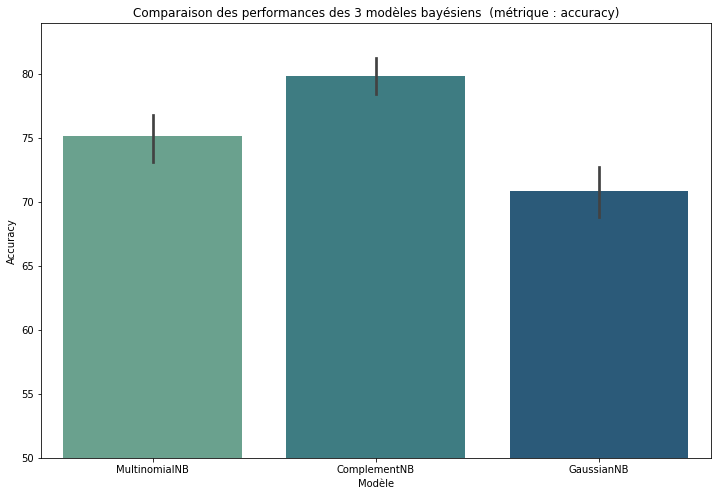

In [106]:
# Comparaison des performances des 3 modèles bayésiens  (métrique : accuracy) 
df_accuracy_melt = pd.melt(df_accuracy, 
                            id_vars = ['Modèle'], 
                            value_name = 'Accuracy', 
                            value_vars=['Accuracy'])
# Visualisation
plt.figure(figsize=(12,8))
sns.barplot(x = df_accuracy_melt['Modèle'],
            y = df_accuracy_melt['Accuracy'], palette = "crest" )
plt.title('Comparaison des performances des 3 modèles bayésiens  (métrique : accuracy)')
plt.ylim(50, 84)
plt.show()

In [39]:
df_accuracy_melt.style.background_gradient()

,Modèle,variable,Accuracy
0,MultinomialNB,Accuracy,72.50000
1,MultinomialNB,Accuracy,78.40000
2,MultinomialNB,Accuracy,76.30000
3,MultinomialNB,Accuracy,72.50000
4,MultinomialNB,Accuracy,76.40000
5,MultinomialNB,Accuracy,76.70000
6,MultinomialNB,Accuracy,59.30000
7,MultinomialNB,Accuracy,68.30000
8,MultinomialNB,Accuracy,76.30000
9,MultinomialNB,Accuracy,70.30000


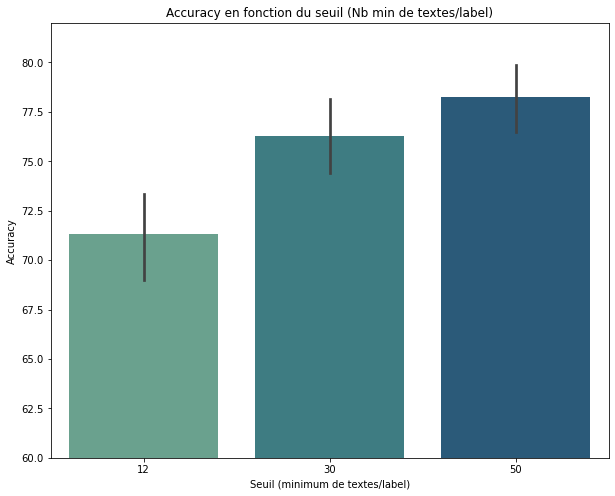

In [104]:
# Accuracy en fonction du seuil (Nb min de textes/label)
df_accuracy_melt = pd.melt(df_accuracy, 
                           id_vars = ['Accuracy'], 
                           value_name = 'Seuil (minimum de textes/label)', value_vars=['Seuil'])
# Visualisation
plt.figure(figsize=(10,8))
sns.barplot(x = df_accuracy_melt['Seuil (minimum de textes/label)'],
            y = df_accuracy_melt['Accuracy'], palette = "crest" )
plt.title('Accuracy en fonction du seuil (Nb min de textes/label)')
plt.ylim(60, 82)
plt.show()

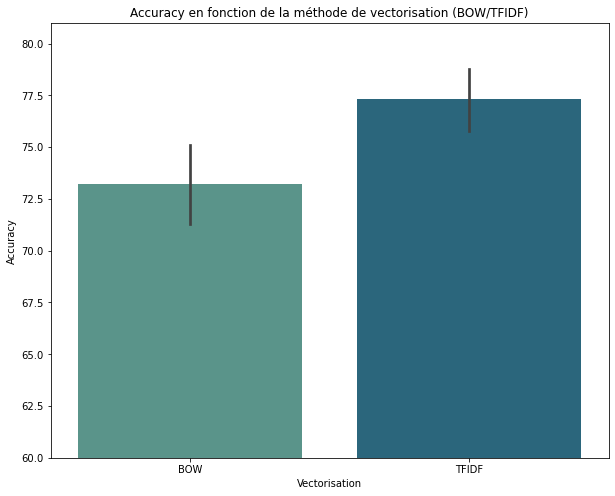

In [102]:
# Accuracy en fonction de la méthode de vectorisation (BOW/TFIDF)
df_accuracy_melt_1 = pd.melt(df_accuracy, 
                             id_vars = ['Accuracy'], 
                             value_name = 'Vectorisation', value_vars=['Vectorisation'])
# Visualisation
plt.figure(figsize=(10,8))
sns.barplot(x = df_accuracy_melt_1['Vectorisation'],
            y = df_accuracy_melt_1['Accuracy'], palette = "crest")
plt.title('Accuracy en fonction de la méthode de vectorisation (BOW/TFIDF)')
plt.ylim(60, 81)
plt.show()

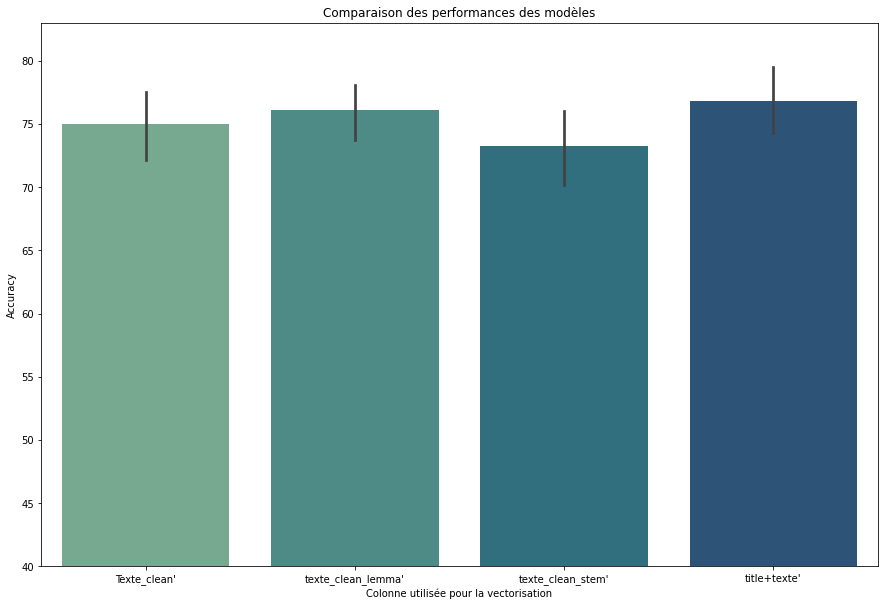

In [98]:
# Accuracy en fonction des colonnes vectorisées 
df_accuracy_melt_2 = pd.melt(df_accuracy, 
                             id_vars = ['Accuracy'], 
                             value_name = 'Colonne utilisée pour la vectorisation', 
                             value_vars=['Colonne'])
#Visualisation
plt.figure(figsize=(15,10))
sns.barplot(x = df_accuracy_melt_2['Colonne utilisée pour la vectorisation'],
            y = df_accuracy_melt_2['Accuracy'], palette = "crest")
plt.title('Comparaison des performances des modèles')
plt.ylim(40, 83)
plt.show()

##### <span style='background:Thistle'>Précision</span> 

In [60]:
import pandas as pd
df_precision = pd.read_excel('resultats_precision.xlsx')

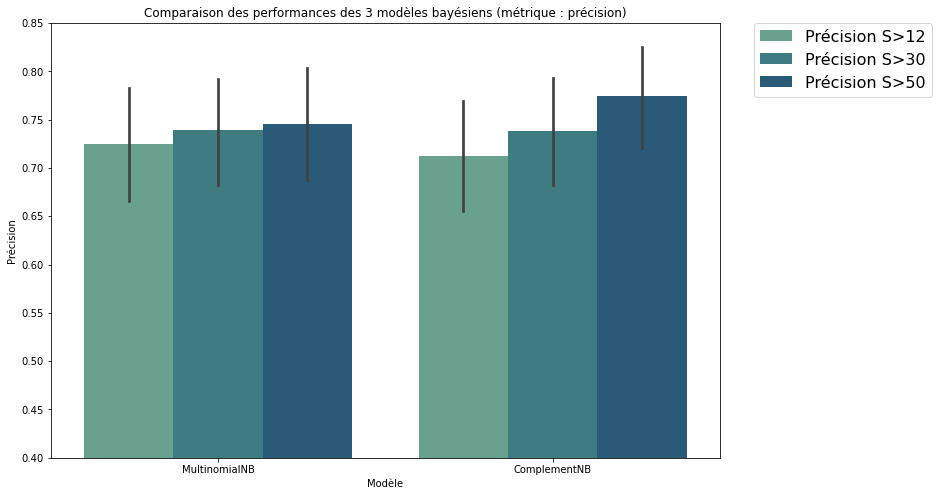

In [97]:
# Comparaison des performances des 3 modèles bayésiens  (métrique : précision) 
df_precision_melt = pd.melt(df_precision, 
                            id_vars = ['Modèle'], 
                            value_name = 'Précision', 
                            value_vars=['Précision S>12', 'Précision S>30', 'Précision S>50'])
# Visualisation
plt.figure(figsize=(12,8))
sns.barplot(x = df_precision_melt['Modèle'],
            y = df_precision_melt['Précision'], hue = df_precision_melt['variable'], palette = "crest" )
plt.title('Comparaison des performances des 3 modèles bayésiens (métrique : précision)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=16)
plt.ylim(0.4, 0.85)
plt.show()

In [62]:
df_precision_melt.style.background_gradient()

,Modèle,variable,Précision
0,MultinomialNB,Précision S>12,0.65500
1,MultinomialNB,Précision S>12,0.87400
2,MultinomialNB,Précision S>12,0.47100
3,MultinomialNB,Précision S>12,0.50000
4,MultinomialNB,Précision S>12,0.93100
5,MultinomialNB,Précision S>12,0.86200
6,MultinomialNB,Précision S>12,0.57700
7,MultinomialNB,Précision S>12,0.57600
8,MultinomialNB,Précision S>12,0.74500
9,MultinomialNB,Précision S>12,0.89000


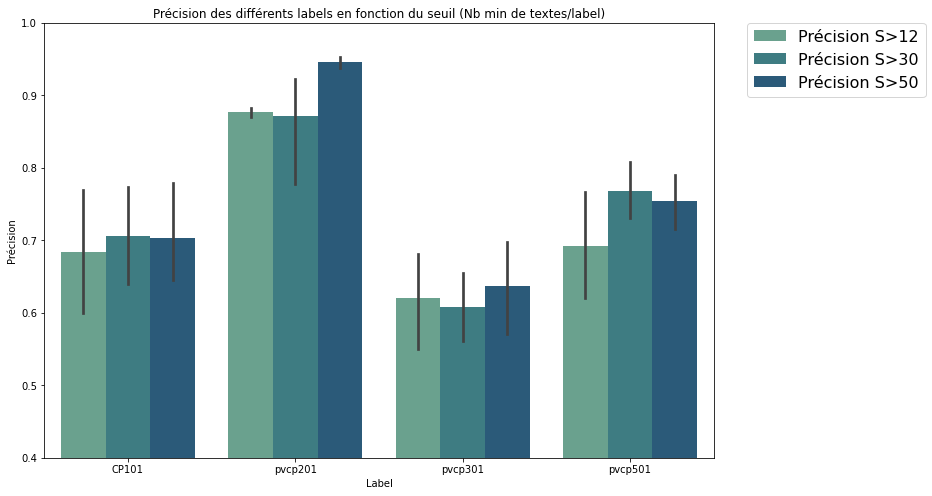

In [95]:
# Précision des différents labels en fonction du seuil (Nb min de textes/label)
df_precision_melt_2 = pd.melt(df_precision, 
                              id_vars = ['Label'], 
                              value_name = 'Précision', 
                              value_vars=['Précision S>12', 'Précision S>30', 'Précision S>50'])
# Visualisation
plt.figure(figsize=(12,8))
sns.barplot(x = df_precision_melt_2['Label'],
            y = df_precision_melt_2['Précision'], hue = df_precision_melt_2['variable'], palette = "crest" )
plt.title('Précision des différents labels en fonction du seuil (Nb min de textes/label)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=16)
plt.ylim(0.4, 1)
plt.show()

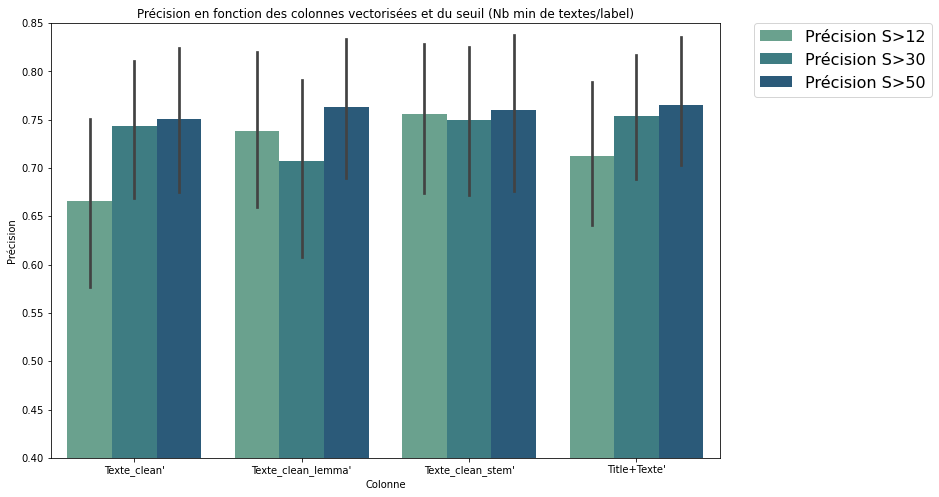

In [93]:
# Précision en fonction des colonnes vectorisées et du seuil (Nb min de textes/label)
df_precision_melt_2 = pd.melt(df_precision, 
                              id_vars = ['Colonne'], 
                              value_name = 'Précision', 
                              value_vars=['Précision S>12', 'Précision S>30', 'Précision S>50'])
# Visualisation
plt.figure(figsize=(12,8))
sns.barplot(x = df_precision_melt_2['Colonne'],
            y = df_precision_melt_2['Précision'], hue = df_precision_melt_2['variable'], palette = "crest" )
plt.title('Précision en fonction des colonnes vectorisées et du seuil (Nb min de textes/label)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=16)
plt.ylim(0.4, 0.85)
plt.show()

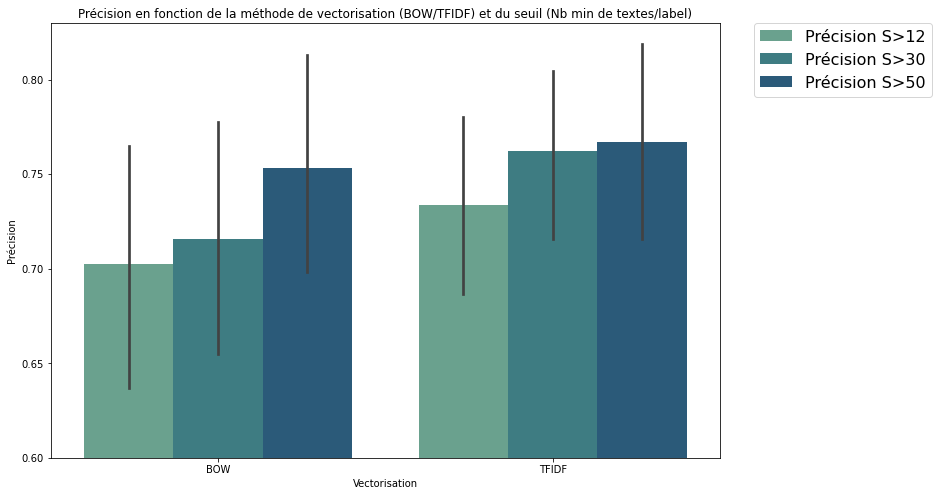

In [89]:
# Précision en fonction de la méthode de vectorisation (BOW/TFIDF) et du seuil (Nb min de textes/label)
df_precision_melt_3 = pd.melt(df_precision,
                              id_vars = ['Vectorisation'], 
                              value_name = 'Précision', 
                              value_vars=['Précision S>12', 'Précision S>30', 'Précision S>50'])
# Visualisation
plt.figure(figsize=(12,8))
sns.barplot(x = df_precision_melt_3['Vectorisation'],
            y = df_precision_melt_3['Précision'], hue = df_precision_melt_3['variable'], palette = "crest" )
plt.title('Précision en fonction de la méthode de vectorisation (BOW/TFIDF) et du seuil (Nb min de textes/label)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=16)
plt.ylim(0.6, 0.83)
plt.show()

#### <span style='background:Moccasin'>Durée d'exécution des 3 modèles</span>

In [76]:
df_duree = pd.read_excel('duree.xlsx')
df_duree

,Modèle,Durée d'exécution (s)
0,MultinomialNB,3.29
1,MultinomialNB,3.15
2,MultinomialNB,3.05
3,MultinomialNB,3.18
4,MultinomialNB,3.09
5,MultinomialNB,2.90
6,MultinomialNB,2.97
7,MultinomialNB,2.87
8,MultinomialNB,2.75
9,MultinomialNB,3.34


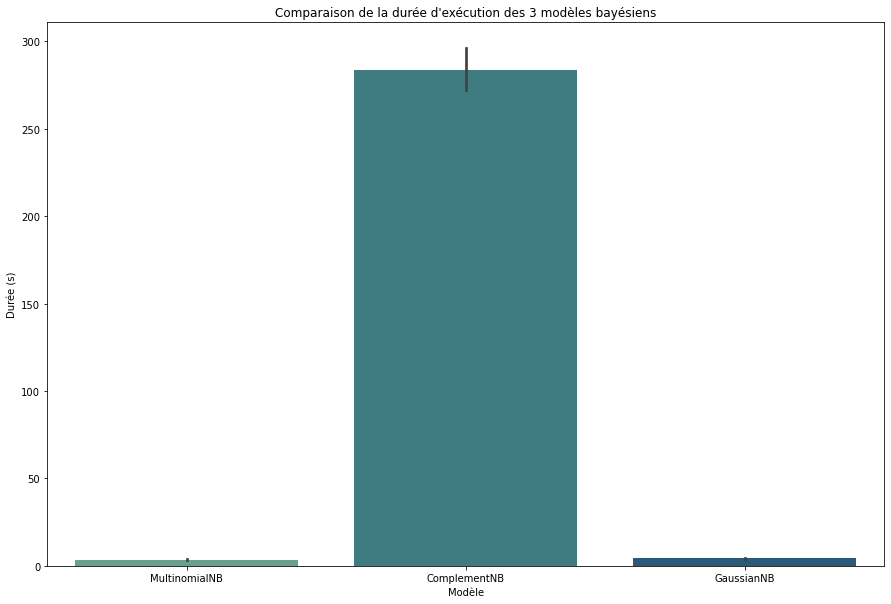

In [78]:
# Comparaison de la durée d'exécution des 3 modèles bayésiens 
df_duree_melt = pd.melt(df_duree, 
                        id_vars = ['Modèle'], 
                        value_name = 'Durée (s)', 
                        value_vars=["Durée d'exécution (s)"])
# Visualisation
plt.figure(figsize=(15,10))
sns.barplot(x = df_duree_melt['Modèle'],
            y = df_duree_melt['Durée (s)'], palette = "crest" )
plt.title("Comparaison de la durée d'exécution des 3 modèles bayésiens")
plt.show()

#### <span style='background:Moccasin'>BOW/TFIDF sur 3 colonnes nettoyées + fusionnées (Title+Texte) AVEC SEUILS</span>
- [x] __Title+Texte_clean__ : nettoyage complet + fusion des colonnes title et texte
- [x] __Title+Texte_lemma__ : nettoyage complet + fusion des colonnes title et texte lemmatisées
- [x] __Title+Texte_stem__ : nettoyage complet + fusion des colonnes title et texte stemmatisées

In [114]:
# BOW/TFIDF sur 3 colonnes nettoyées + fusionnées (Title+Texte) AVEC SEUILS
# Modèles NAIVES BAYES MultinomialNB(), ComplementNB(), GaussianNB()

df_clean = df_work[["texte", "title_clean", 'title_lemma', 'title_stem', 'texte_clean', 'texte_clean_lemma', "texte_clean_stem","label"]]
df_clean["Title+Texte_clean"] = df_work["title_clean"] + " " + df_work["texte_clean"]
df_clean["Title+Texte_lemma"] = df_work["title_lemma"] + " " + df_work["texte_clean_lemma"]
df_clean["Title+Texte_stem"] = df_work["title_stem"] + " " + df_work["texte_clean_stem"]

list_vectorizer = [BagOfWords, TFIDF]
list_classifier = [MNB_RIVER(), ComplementNB(), GaussianNB()]
list_colonnes = ["Title+Texte_clean", "Title+Texte_lemma", "Title+Texte_stem"]
list_seuil = [12, 30, 50]

In [115]:
print('*****************************************************************************************************')
print('')
print(f'*******************************    Modèles :  NAIVES BAYES   ***************************************')
print('')
print('')
print(f'*******************************     Essais complémentaires    **************************************')
print('')
print(f'*******************************      COLONNES TITLE+TEXTE     **************************************')
print('')
print('*****************************************************************************************************')
print('')
print('')
print('')
for vectorizer in list_vectorizer :
    for classifier in list_classifier:
        for col in list_colonnes:
            for seuil in list_seuil:
                model_for_river(df_clean, seuil, vectorizer, col, classifier)

*****************************************************************************************************

*******************************    Modèles :  NAIVES BAYES   ***************************************


*******************************     Essais complémentaires    **************************************

*******************************      COLONNES TITLE+TEXTE     **************************************

*****************************************************************************************************





********************************************************************************************************

                               Colonne vectorisée : Title+Texte_clean                                          

Vectorisation : <class 'river.feature_extraction.vectorize.BagOfWords'>                                                                            
Modèle : MultinomialNB                                                                                   
Seuil : 12

#######################################    RESULTATS    ##################################################

           Precision   Recall   F1      Support  
                                                 
   CP101       0.897    0.729   0.805        48  
 pvcp201       0.903    0.778   0.836       167  
 pvcp202       0.286    0.400   0.333         5  
 pvcp203       0.000    0.000   0.000         5  
 pvcp204       0.389    0.778   0.519         9  
 pvcp301       0.483    0.933   0.636        15  
 pvcp501       0.600    0.947   0.735        19  
 pvcp601       1.000    0.200   0.333         5  
                                                 
   Macro       0.570    0.596   0.525            
   Micro       0.758    0.758   0.758            
Weighted       0.815    0.758   0.768            

                 75.8% accuracy                  
Durée : 3.3038816452026367






********************************************************************************************************

  

#######################################    RESULTATS    ##################################################

           Precision   Recall   F1      Support  
                                                 
   CP101       0.889    0.667   0.762        48  
 pvcp201       0.924    0.653   0.765       167  
 pvcp202       0.000    0.000   0.000            
 pvcp203       0.000    0.000   0.000            
 pvcp204       0.212    0.700   0.326         1  
 pvcp301       0.424    0.933   0.583        15  
 pvcp501       0.731    1.000   0.844        19  
                                                 
   Macro       0.454    0.565   0.469            
   Micro       0.699    0.699   0.699            
Weighted       0.847    0.699   0.743            

                 69.9% accuracy                  
Durée : 3.0112969875335693






********************************************************************************************************

                               Colonne vectorisée : 

#######################################    RESULTATS    ##################################################

           Precision   Recall   F1      Support  
                                                 
   CP101       0.667    0.875   0.757        48  
 pvcp201       0.968    0.892   0.928       167  
 pvcp301       0.692    0.600   0.643        15  
 pvcp501       0.789    0.789   0.789        19  
                                                 
   Macro       0.779    0.789   0.779            
   Micro       0.863    0.863   0.863            
Weighted       0.879    0.863   0.867            

                 86.3% accuracy                  
Durée : 245.8058750629425






********************************************************************************************************

                               Colonne vectorisée : Title+Texte_lemma                                          

Vectorisation : <class 'river.feature_extraction.vectorize.BagOfWords'>                   

#######################################    RESULTATS    ##################################################

           Precision   Recall   F1      Support  
                                                 
   CP101       0.544    0.896   0.677        48  
 pvcp201       0.901    0.874   0.888       167  
 pvcp202       0.000    0.000   0.000         5  
 pvcp203       0.000    0.000   0.000         5  
 pvcp204       1.000    0.556   0.714         9  
 pvcp301       0.667    0.400   0.500        15  
 pvcp501       0.833    0.789   0.811        19  
 pvcp601       0.000    0.000   0.000         5  
                                                 
   Macro       0.493    0.439   0.449            
   Micro       0.788    0.788   0.788            
Weighted       0.775    0.788   0.769            

                 78.8% accuracy                  
Durée : 302.1620948314667






********************************************************************************************************

   

#######################################    RESULTATS    ##################################################

           Precision   Recall   F1      Support  
                                                 
   CP101       0.667    0.333   0.444        48  
 pvcp201       0.692    0.970   0.808       167  
 pvcp204       0.000    0.000   0.000         1  
 pvcp301       1.000    0.067   0.125        15  
 pvcp501       0.000    0.000   0.000        19  
                                                 
   Macro       0.472    0.274   0.275            
   Micro       0.691    0.691   0.691            
Weighted       0.628    0.691   0.611            

                 69.1% accuracy                  
Durée : 3.767569065093994






********************************************************************************************************

                               Colonne vectorisée : Title+Texte_clean                                          

Vectorisation : <class 'river.feature_ex

#######################################    RESULTATS    ##################################################

           Precision   Recall   F1      Support  
                                                 
   CP101       0.680    0.354   0.466        48  
 pvcp201       0.730    0.970   0.833       167  
 pvcp301       1.000    0.133   0.235        15  
 pvcp501       0.000    0.000   0.000        19  
                                                 
   Macro       0.602    0.364   0.383            
   Micro       0.727    0.727   0.727            
Weighted       0.681    0.727   0.663            

                 72.7% accuracy                  
Durée : 3.5147101879119873






********************************************************************************************************

                               Colonne vectorisée : Title+Texte_stem                                          

Vectorisation : <class 'river.feature_extraction.vectorize.BagOfWords'>                   

#######################################    RESULTATS    ##################################################

           Precision   Recall   F1      Support  
                                                 
   CP101       0.933    0.583   0.718        48  
 pvcp201       0.866    0.814   0.840       167  
 pvcp202       0.083    0.200   0.118         5  
 pvcp203       0.000    0.000   0.000         5  
 pvcp204       0.667    0.667   0.667         9  
 pvcp301       0.577    1.000   0.732        15  
 pvcp501       0.543    1.000   0.704        19  
 pvcp601       0.500    0.200   0.286         5  
                                                 
   Macro       0.521    0.558   0.508            
   Micro       0.755    0.755   0.755            
Weighted       0.796    0.755   0.758            

                 75.5% accuracy                  
Durée : 4.266576528549194






********************************************************************************************************

   

#######################################    RESULTATS    ##################################################

           Precision   Recall   F1      Support  
                                                 
   CP101       0.879    0.604   0.716        48  
 pvcp201       0.914    0.826   0.868       167  
 pvcp202       0.000    0.000   0.000            
 pvcp203       0.000    0.000   0.000            
 pvcp204       0.714    0.500   0.588         1  
 pvcp301       0.538    0.933   0.683        15  
 pvcp501       0.679    1.000   0.809        19  
 pvcp601       0.000    0.000   0.000            
                                                 
   Macro       0.466    0.483   0.458            
   Micro       0.792    0.792   0.792            
Weighted       0.861    0.792   0.814            

                 79.2% accuracy                  
Durée : 4.008600950241089






********************************************************************************************************

   

#######################################    RESULTATS    ##################################################

           Precision   Recall   F1      Support  
                                                 
   CP101       0.871    0.562   0.684        48  
 pvcp201       0.920    0.826   0.871       167  
 pvcp202       0.000    0.000   0.000            
 pvcp203       0.000    0.000   0.000            
 pvcp204       0.000    0.000   0.000            
 pvcp301       0.560    0.933   0.700        15  
 pvcp501       0.633    1.000   0.776        19  
                                                 
   Macro       0.426    0.475   0.433            
   Micro       0.795    0.795   0.795            
Weighted       0.867    0.795   0.817            

                 79.5% accuracy                  
Durée : 3.637430429458618






********************************************************************************************************

                               Colonne vectorisée : T

#######################################    RESULTATS    ##################################################

           Precision   Recall   F1      Support  
                                                 
   CP101       0.618    0.875   0.724        48  
 pvcp201       0.896    0.874   0.885       167  
 pvcp202       0.000    0.000   0.000         5  
 pvcp203       0.000    0.000   0.000         5  
 pvcp204       1.000    0.444   0.615         9  
 pvcp301       0.786    0.733   0.759        15  
 pvcp501       0.727    0.842   0.780        19  
 pvcp601       1.000    0.400   0.571         5  
                                                 
   Macro       0.628    0.521   0.542            
   Micro       0.810    0.810   0.810            
Weighted       0.802    0.810   0.795            

                 81.0% accuracy                  
Durée : 328.32866287231445






********************************************************************************************************

  

#######################################    RESULTATS    ##################################################

           Precision   Recall   F1      Support  
                                                 
   CP101       0.645    0.833   0.727        48  
 pvcp201       0.930    0.874   0.901       167  
 pvcp204       1.000    0.400   0.571         1  
 pvcp301       0.733    0.733   0.733        15  
 pvcp501       0.810    0.895   0.850        19  
                                                 
   Macro       0.824    0.747   0.757            
   Micro       0.842    0.842   0.842            
Weighted       0.860    0.842   0.843            

                 84.2% accuracy                  
Durée : 281.7982861995697






********************************************************************************************************

                               Colonne vectorisée : Title+Texte_stem                                          

Vectorisation : <class 'river.feature_ext

#######################################    RESULTATS    ##################################################

           Precision   Recall   F1      Support  
                                                 
   CP101       0.692    0.188   0.295        48  
 pvcp201       0.795    0.928   0.856       167  
 pvcp203       0.000    0.000   0.000            
 pvcp204       0.000    0.000   0.000            
 pvcp301       1.000    1.000   1.000        15  
 pvcp501       0.857    0.947   0.900        19  
                                                 
   Macro       0.557    0.511   0.509            
   Micro       0.791    0.791   0.791            
Weighted       0.792    0.791   0.760            

                 79.1% accuracy                  
Durée : 4.754209280014038






********************************************************************************************************

                               Colonne vectorisée : Title+Texte_lemma                                  

#######################################    RESULTATS    ##################################################

           Precision   Recall   F1      Support  
                                                 
   CP101       0.615    0.167   0.262        48  
 pvcp201       0.677    0.916   0.779       167  
 pvcp202       0.500    0.200   0.286         5  
 pvcp203       0.000    0.000   0.000         5  
 pvcp204       0.667    0.444   0.533         9  
 pvcp301       1.000    0.133   0.235        15  
 pvcp501       0.625    0.789   0.698        19  
 pvcp601       0.000    0.000   0.000         5  
                                                 
   Macro       0.511    0.331   0.349            
   Micro       0.670    0.670   0.670            
Weighted       0.652    0.670   0.607            

                 67.0% accuracy                  
Durée : 4.797263145446777






********************************************************************************************************

   

#### <span style='background:Moccasin'>VISUALISATIONS DES RESULTATS</span>

##### <span style='background:Thistle'>Accuracy</span> 

In [79]:
df_accuracy_titleTexte = pd.read_excel('resultats_accuracy_titleTexte.xlsx')
df_accuracy_titleTexte

,Colonne,Vectorisation,Modèle,Seuil,Accuracy
0,title+texte_clean',BOW,MultinomialNB,12,77.7
1,title+texte_clean',BOW,MultinomialNB,30,82.2
2,title+texte_clean',BOW,MultinomialNB,50,81.1
3,title+texte_lemma',BOW,MultinomialNB,12,75.8
4,title+texte_lemma',BOW,MultinomialNB,30,80.7
5,title+texte_lemma',BOW,MultinomialNB,50,80.3
6,title+texte_stem',BOW,MultinomialNB,12,60.4
7,title+texte_stem',BOW,MultinomialNB,30,69.9
8,title+texte_stem',BOW,MultinomialNB,50,77.5
9,title+texte_clean',BOW,ComplementNB,12,76.2


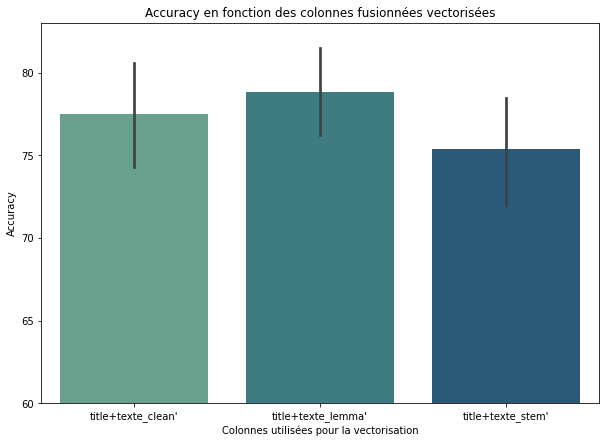

In [113]:
# Accuracy en fonction des colonnes fusionnées vectorisées 
df_accuracy_titleTexte_melt = pd.melt(df_accuracy_titleTexte, 
                             id_vars = ['Accuracy'], 
                             value_name = 'Colonnes utilisées pour la vectorisation', 
                             value_vars=['Colonne'])
#Visualisation
plt.figure(figsize=(10,7))
plt.ylim(60, 83)
sns.barplot(x = df_accuracy_titleTexte_melt['Colonnes utilisées pour la vectorisation'],
            y = df_accuracy_titleTexte_melt['Accuracy'], palette = "crest")
plt.title('Accuracy en fonction des colonnes fusionnées vectorisées')
plt.show()

##### <span style='background:Thistle'>Précision</span> 

In [68]:
df_precision_titleTexte = pd.read_excel ('resultats_precision_titleTexte.xlsx')
df_precision_titleTexte

,Label,Colonne,Vectorisation,Modèle,Précision S>12,Précision S>30,Précision S>50
0,CP101,title+texte_clean',BOW,MultinomialNB,0.826,0.878,0.854
1,pvcp201,title+texte_clean',BOW,MultinomialNB,0.888,0.945,0.958
2,pvcp301,title+texte_clean',BOW,MultinomialNB,0.562,0.538,0.481
3,pvcp501,title+texte_clean',BOW,MultinomialNB,0.500,0.704,0.720
4,CP101,title+texte_lemma',BOW,MultinomialNB,0.897,0.875,0.854
5,pvcp201,title+texte_lemma',BOW,MultinomialNB,0.903,0.950,0.957
6,pvcp301,title+texte_lemma',BOW,MultinomialNB,0.600,0.519,0.500
7,pvcp501,title+texte_lemma',BOW,MultinomialNB,1.000,0.731,0.750
8,CP101,title+texte_stem',BOW,MultinomialNB,0.882,0.889,0.829
9,pvcp201,title+texte_stem',BOW,MultinomialNB,0.907,0.924,0.941


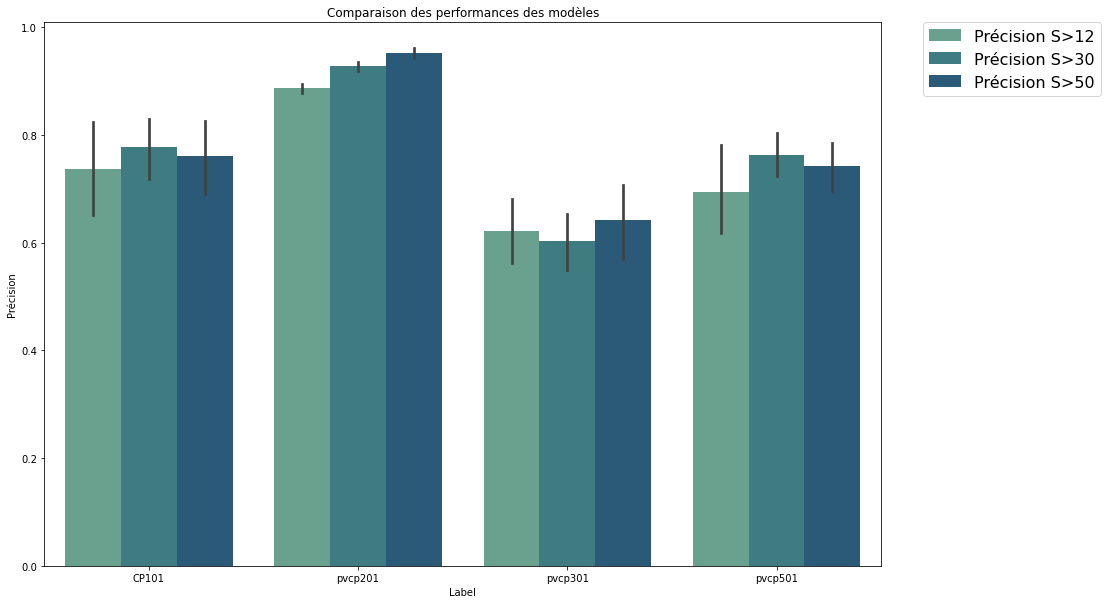

In [69]:
# Précision des différents labels en fonction du seuil (Nb min de textes/label)
df_precision_titleTexte_melt = pd.melt(df_precision_titleTexte, 
                                       id_vars = ['Label'], 
                                       value_name = 'Précision', 
                                       value_vars=['Précision S>12', 'Précision S>30', 'Précision S>50'])
# Visualisation
plt.figure(figsize=(15,10))
sns.barplot(x = df_precision_titleTexte_melt['Label'],
            y = df_precision_titleTexte_melt['Précision'], hue = df_precision_titleTexte_melt['variable'], palette = "crest" )
plt.title('Comparaison des performances des modèles')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=16)
plt.show()

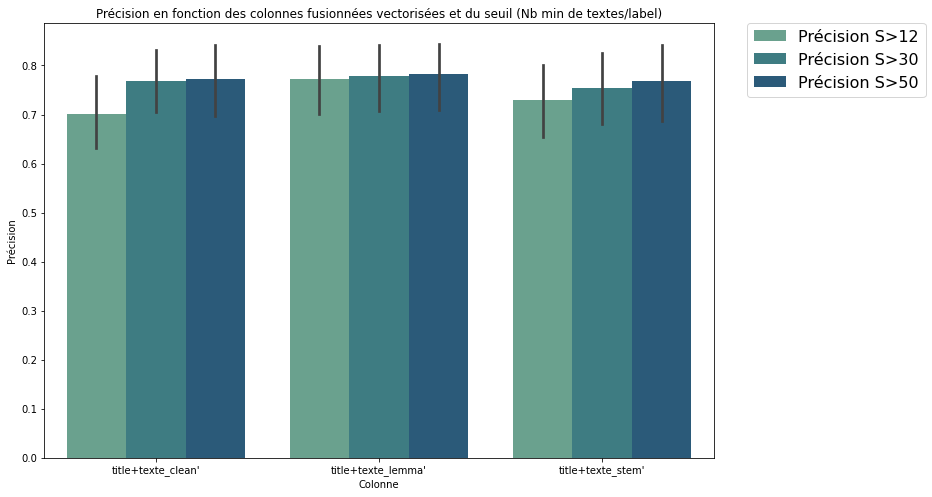

In [70]:
# Précision en fonction des colonnes fusionnées vectorisées et du seuil (Nb min de textes/label)
df_precision_titleTexte_melt = pd.melt(df_precision_titleTexte, 
                                       id_vars = ['Colonne'], 
                                       value_name = 'Précision', 
                                       value_vars=['Précision S>12', 'Précision S>30', 'Précision S>50'])
# Visualisation
plt.figure(figsize=(12,8))
sns.barplot(x = df_precision_titleTexte_melt['Colonne'],
            y = df_precision_titleTexte_melt['Précision'], hue = df_precision_titleTexte_melt['variable'], palette = "crest" )
plt.title('Précision en fonction des colonnes fusionnées vectorisées et du seuil (Nb min de textes/label)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=16)
plt.show()

#### <span style='background:Moccasin'>BOW/TFIDF sur 3 colonnes nettoyées + fusionnées (Title+Texte) SANS SEUIL</span>
- [x] __Title+Texte_clean__ : nettoyage complet + fusion des colonnes title et texte
- [x] __Title+Texte_lemma__ : nettoyage complet + fusion des colonnes title et texte lemmatisées
- [x] __Title+Texte_stem__ : nettoyage complet + fusion des colonnes title et texte stemmatisées

In [116]:
#Précision labels

df_clean = df_work[["texte", "title_clean", 'title_lemma', 'title_stem', 'texte_clean', 'texte_clean_lemma', "texte_clean_stem","label"]]
df_clean["Title+Texte_clean"] = df_work["title_clean"] + " " + df_work["texte_clean"]
df_clean["Title+Texte_lemma"] = df_work["title_lemma"] + " " + df_work["texte_clean_lemma"]
df_clean["Title+Texte_stem"] = df_work["title_stem"] + " " + df_work["texte_clean_stem"]

list_vectorizer = [BagOfWords, TFIDF]
list_classifier = [ComplementNB()]
list_colonnes = ["Title+Texte_clean", "Title+Texte_lemma","Title+Texte_stem" ]
list_seuil = [4]

In [117]:
print('*****************************************************************************************************')
print('')
print(f'**************************************    SANS SEUIL   *********************************************')
print('')
print(f'*************************    Modèle :  NAIVES BAYES ComplementNB   *********************************')
print('')
print(f'*********************    Colonnes :  "Title+Texte"_clean, _lemma, _stem"  **************************')
print('')
print(f'****************************    Vectorisation : BagOfWords - TFIDF  ********************************')
print('')
print('*****************************************************************************************************')
print('')
print('')
print('')
for vectorizer in list_vectorizer :
    for classifier in list_classifier:
        for col in list_colonnes:
            for seuil in list_seuil:
                model_for_river(df_clean, seuil, vectorizer, col, classifier)

*****************************************************************************************************

**************************************    SANS SEUIL   *********************************************

*************************    Modèle :  NAIVES BAYES ComplementNB   *********************************

*********************    Colonnes :  "Title+Texte"_clean, _lemma, _stem"  **************************

****************************    Vectorisation : BagOfWords - TFIDF  ********************************

*****************************************************************************************************





********************************************************************************************************

                               Colonne vectorisée : Title+Texte_clean                                          

Vectorisation : <class 'river.feature_extraction.vectorize.BagOfWords'>                                                                            
Modèle : Comple

#######################################    RESULTATS    ##################################################

           Precision   Recall   F1      Support  
                                                 
   CP101       0.534    0.812   0.645        48  
   CP103       0.000    0.000   0.000         1  
   cp102       0.000    0.000   0.000         2  
   cp104       0.000    0.000   0.000         2  
 pvcp201       0.874    0.832   0.853       167  
 pvcp202       0.000    0.000   0.000         5  
 pvcp203       0.000    0.000   0.000         5  
 pvcp204       0.429    0.300   0.353         1  
 pvcp301       0.538    0.467   0.500        15  
 pvcp501       0.667    0.737   0.700        19  
 pvcp601       1.000    0.800   0.889         5  
                                                 
   Macro       0.367    0.359   0.358            
   Micro       0.738    0.738   0.738            
Weighted       0.723    0.738   0.724            

                 73.8% accuracy          

In [72]:
df_precision_labels = pd.read_excel('précision_labels.xlsx')
df_precision_labels

,Label,Colonne,Vectorisation,Précision
0,CP101,Title+Texte_clean,BOW,0.547
1,CP103,Title+Texte_clean,BOW,0.000
2,cp102,Title+Texte_clean,BOW,0.000
3,cp104,Title+Texte_clean,BOW,0.000
4,pvcp201,Title+Texte_clean,BOW,0.868
5,pvcp202,Title+Texte_clean,BOW,0.000
6,pvcp203,Title+Texte_clean,BOW,0.000
7,pvcp204,Title+Texte_clean,BOW,0.500
8,pvcp301,Title+Texte_clean,BOW,0.455
9,pvcp501,Title+Texte_clean,BOW,0.667


#### <span style='background:Moccasin'>VISUALISATIONS DES RESULTATS</span>

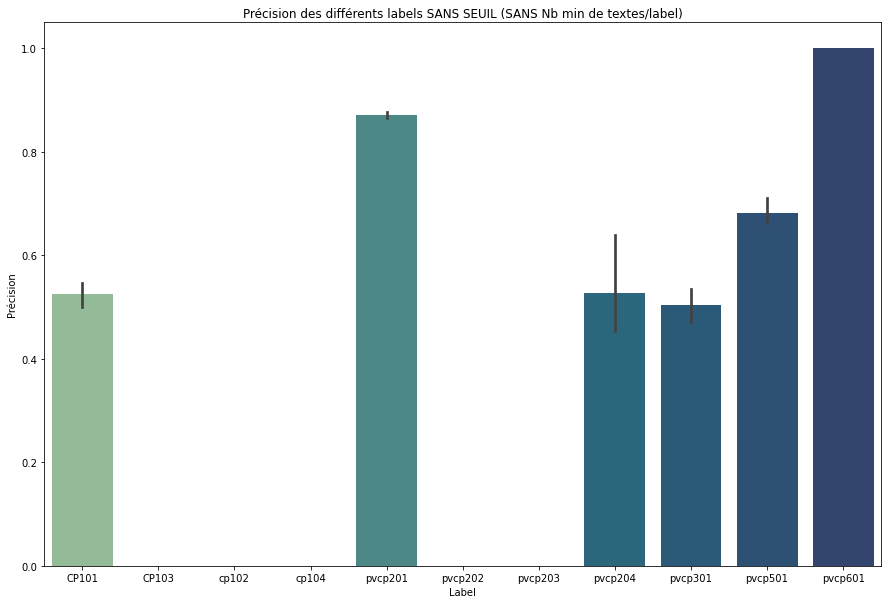

In [73]:
# Précision des différents labels SANS SEUIL (SANS Nb min de textes/label)
df_precision_labels_melt = pd.melt(df_precision_labels, 
                                   id_vars = ['Label'], 
                                   value_name = 'Précision', 
                                   value_vars=['Précision'])
# Visualisation
plt.figure(figsize=(15,10))
sns.barplot(x = df_precision_labels_melt['Label'],
            y = df_precision_labels_melt['Précision'], palette = "crest" )
plt.title('Précision des différents labels SANS SEUIL (SANS Nb min de textes/label)')
plt.show()